# Basic scVI Tutorial

In [1]:
cd ../..

/home/jeff/git/scVI


In [2]:
import os

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from scvi.dataset import CortexDataset, RetinaDataset

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.metrics.differential_expression import de_stats
from scvi.metrics.imputation import imputation

from scvi.models import VAE, SVAEC

from scvi.inference import VariationalInference

## Loading data

Here we load the CORTEX dataset described in

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

Please see our data loading Jupyter notebook for more examples of data loading -- scVI has many "built-in" datasets, as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files.

In [3]:
gene_dataset = CortexDataset()

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA. 


In [4]:
n_epochs=500
lr=1e-3
use_batches=False
use_cuda=True

**Train the model and output model likelihood every 5 epochs**

In [5]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
infer = VariationalInference(vae, 
                             gene_dataset, 
                             train_size=0.9, 
                             use_cuda=use_cuda,
                             frequency=5)
infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 500/500 [01:15<00:00,  6.62it/s]


** Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

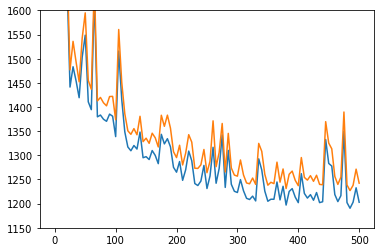

In [6]:
ll_train = infer.history["ll_train"]
ll_test = infer.history["ll_test"]
x = np.linspace(0,500,(len(ll_train)))
plt.plot(x, ll_train)
plt.plot(x, ll_test)
plt.ylim(1150,1600)
plt.show()

## Visualizing the latent space

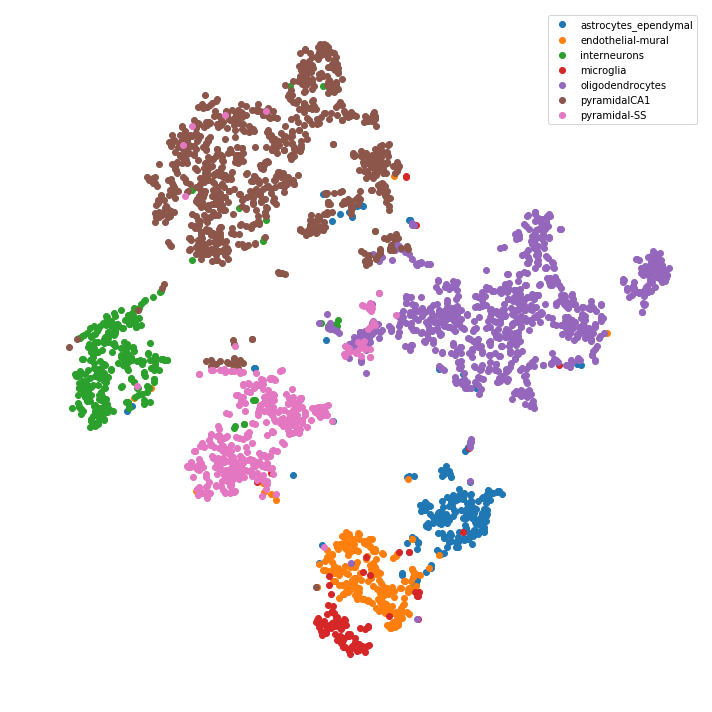

In [7]:
infer.show_t_sne('sequential', n_samples=False, color_by='labels')

## Imputation
Parameters:
* The rate of simulated dropout is defined by __rate__, here set ot 0.3 

To check the imputation accuracy of the model, we iterate over each batch of input count matrix (n_sample\*n_genes), randomly induce dropouts by changing non-zero values in the matrix (__sample_batch__) to zero, and obtain the imputed value (__px_rate__) from the trained VAE model at those positions. We then plot the distribution of absolute errors between the imputed value and the true value at the dropout positions. 

Note: The imputed value __px_rate__ is the rate parameter (expected value) of the Zero-Inflated Negative Binomial (ZINB) distribution.

In [8]:
imputation_errors = infer.imputation_errors('test', rate=0.3)

(array([4.0000e+00, 1.1000e+01, 7.6000e+01, 4.7800e+02, 2.7810e+03,
        1.0819e+04, 1.6454e+04, 4.9960e+03, 2.7500e+02, 6.0000e+01]),
 array([-4.32054567, -3.53560464, -2.75066361, -1.96572258, -1.18078156,
        -0.39584053,  0.3891005 ,  1.17404153,  1.95898256,  2.74392359,
         3.52886462]),
 <a list of 10 Patch objects>)

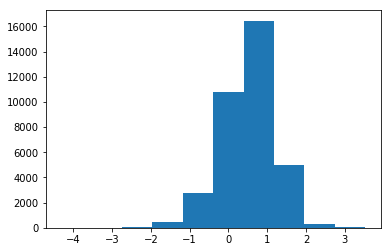

In [9]:
plt.hist(np.log10(imputation_errors))

## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [10]:
cell_types = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons', 'microglia',
                       'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'], dtype=np.str)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))


Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



**2. Define parameters**
* __M_sampling__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [11]:
M_sampling = 100 
M_permutation = 100000
permutation = False

**3. Sample from the gene expression level from all cells**
Note: The expectation of the ZINB distribution __px_rate ~ library_size * px_scale__, so __px_scale__ could be understood as the mean gene expression level of each cell after adjusting for the library size factor. 

In [12]:
px_scale, all_labels = infer.differential_expression_stats('train')

**4. Extract the sampled gene expression level for the two populations of interest, and create indexes for the samples**

In [13]:
sample_rate_a = px_scale[all_labels.view(-1) == couple_celltypes[0]].view(-1, px_scale.size(1)).cpu().detach().numpy()
sample_rate_b = px_scale[all_labels.view(-1) == couple_celltypes[1]].view(-1, px_scale.size(1)).cpu().detach().numpy()

list_1 = list(np.arange(sample_rate_a.shape[0]))
list_2 = list(sample_rate_a.shape[0] + np.arange(sample_rate_b.shape[0]))

samples = np.vstack((sample_rate_a, sample_rate_b))

**5. Compute whether a gene is differentially expressed by computing pairs of cells from population A and population B**

In [14]:
u, v = np.random.choice(list_1, size=M_permutation), np.random.choice(list_2, size=M_permutation)
first_set = samples[u]
second_set = samples[v]
res1 = np.mean(first_set >= second_set, 0)
res1 = np.log(res1 + 1e-8) - np.log(1 - res1 + 1e-8)

**6. Obtaining the null value by comparing pairs sampled from the combined population**

In [15]:
u, v = (np.random.choice(list_1 + list_2, size=M_permutation),
    np.random.choice(list_1 + list_2, size=M_permutation))
first_set = samples[u]
second_set = samples[v]
res2 = np.mean(first_set >= second_set, 0)
res2 = np.log(res2 + 1e-8) - np.log(1 - res2 + 1e-8)

**7. Print out the differential expression value from both the true comparison and the permuted comparison**

In [16]:
genes_of_interest = ["Thy1", "Mbp"]
gene_names = infer.gene_dataset.gene_names
result = [(gene_name, res1[np.where(gene_names == gene_name.upper())[0]][0],res2[np.where(gene_names == gene_name.upper())[0]][0]) for gene_name in genes_of_interest]
print('\n'.join([gene_name + " : " + str(r1) + " , "+ str(r2) for (gene_name, r1,r2) in result]))

Thy1 : -5.057694442863545 , 0.004000005253345873
Mbp : 5.133726741796103 , -0.0020000006266669423


**8. Plot the null distribution of the DE values**

(array([ 17.,  25.,  65.,  95.,  88., 120.,  91.,  41.,  15.,   1.]),
 array([-0.01596034, -0.01225623, -0.00855211, -0.004848  , -0.00114389,
         0.00256022,  0.00626433,  0.00996844,  0.01367256,  0.01737667,
         0.02108078]),
 <a list of 10 Patch objects>)

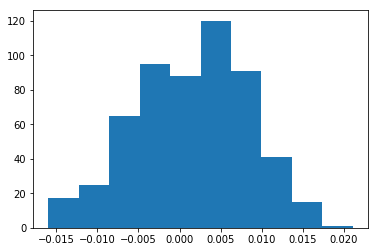

In [17]:
plt.hist(res2)

## Correction for batch effects

First we load the RETINA dataset that is described in

* Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.

In [18]:
gene_dataset = RetinaDataset()

File data/retina.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [20]:
n_epochs=100
lr=1e-3
use_batches=True
use_cuda=True

### Train the model and output model likelihood every 5 epochs
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
infer = VariationalInference(vae, 
                             gene_dataset, 
                             train_size=0.9, 
                             use_cuda=use_cuda,
                             frequency=5)
infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 100/100 [13:27<00:00,  8.07s/it]


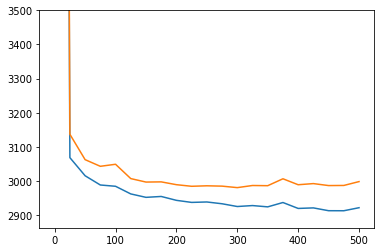

In [24]:
# Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error. 

ll_train = infer.history["ll_train"]
ll_test = infer.history["ll_test"]
x = np.linspace(0,500,(len(ll_train)))
plt.plot(x, ll_train)
plt.plot(x, ll_test)
plt.ylim(min(ll_train)-50, 3500)
plt.show()

**Computing batch mixing**

In [25]:
print("Entropy batch mixing :", infer.entropy_batch_mixing('sequential'))

Entropy batch mixing : 0.6587664259373629


**Coloring by batch and cell type**

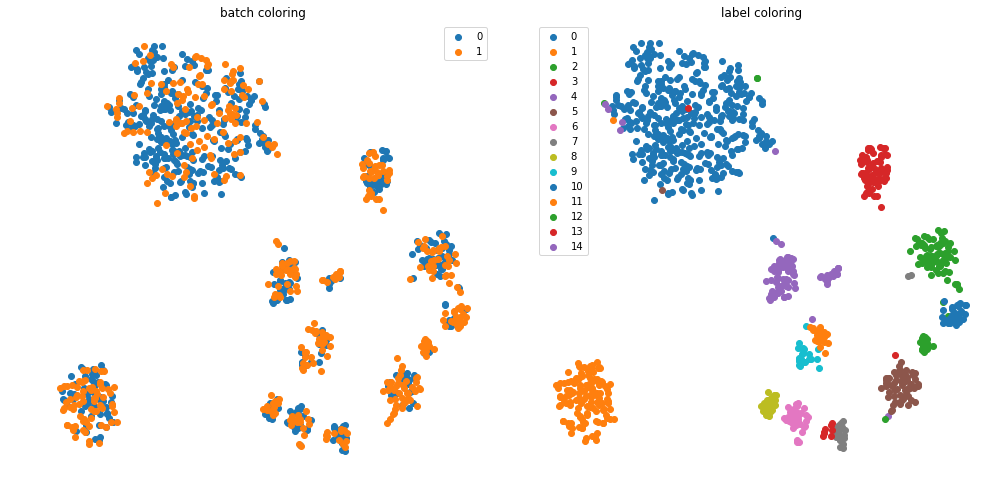

In [26]:
# obtaining latent space in the same order as the input data

infer.show_t_sne('sequential',n_samples=1000, color_by='batches and labels')